# 04_06_ridge_and_lasso

Author: Justin A Johnson. Adapted from sklearn documentation and original content. License: Modified BSD License.

In [67]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_diabetes
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets, linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

Again we're going to use our diabetes dataset. Inspect it again just to remind yourself
what is in it.

In [68]:
diabetes = load_diabetes()

X = diabetes.data
y = diabetes.target

feature_names = diabetes.feature_names

print(diabetes['DESCR'])
print(feature_names)



.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

To speed up calculation, we're going to just use the first 150 observations
using numpy slice notation to grab them out of the X, y

In [69]:
X = X[:150]
y = y[:150]
X
y

array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
        69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
        68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
        87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
       259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
       128.,  52.,  37., 170., 170.,  61., 144.,  52., 128.,  71., 163.,
       150.,  97., 160., 178.,  48., 270., 202., 111.,  85.,  42., 170.,
       200., 252., 113., 143.,  51.,  52., 210.,  65., 141.,  55., 134.,
        42., 111.,  98., 164.,  48.,  96.,  90., 162., 150., 279.,  92.,
        83., 128., 102., 302., 198.,  95.,  53., 134., 144., 232.,  81.,
       104.,  59., 246., 297., 258., 229., 275., 281., 179., 200., 200.,
       173., 180.,  84., 121., 161.,  99., 109., 115., 268., 274., 158.,
       107.,  83., 103., 272.,  85., 280., 336., 281., 118., 317., 235.,
        60., 174., 259., 178., 128.,  96., 126.])

# Class exercise: Review of OLS. Report back the MSE  of y versus the predicted y when you use the X and y variables above.
You might want to utilize the scikit-learn linear regression tools, in particular the following functions:

linear_model.LinearRegression()
.fit(X, y)
.predict(X)
mean_squared_error(y, y_pred)

In addition to the scikit-learn OLS, we also will be using today
the statsmodels implementation. Let's go ahead an import it.
I'm assuming you've already run conda install statsmodels -c conda-forge in your
anaconda command line.

In [70]:
from statsmodels.api import OLS

statsmodels uses a similar syntax to scikit learn of createing a model, fitting it, and
returning the summary.

In [71]:
model = OLS(y, X)
fitted_model = model.fit()
result = fitted_model.summary()

print(result)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.120
Model:                            OLS   Adj. R-squared (uncentered):              0.057
Method:                 Least Squares   F-statistic:                              1.915
Date:                Tue, 07 Dec 2021   Prob (F-statistic):                      0.0478
Time:                        13:55:01   Log-Likelihood:                         -969.69
No. Observations:                 150   AIC:                                      1959.
Df Residuals:                     140   BIC:                                      1989.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Today's goal, however, is to do Lasso on this same dataset.
To start, lets create a Lasso object. Notice that we are not
setting the alpha/gamma value when we create it.

In [48]:
lasso = Lasso(random_state=0, max_iter=10000)
lasso

Lasso(max_iter=10000, random_state=0)

Instead, we are going to test a variety of different alphas, as here:

In [49]:
alphas = np.logspace(-3, -0.5, 30)
alphas

array([0.001     , 0.00121957, 0.00148735, 0.00181393, 0.00221222,
       0.00269795, 0.00329034, 0.00401281, 0.0048939 , 0.00596846,
       0.00727895, 0.0088772 , 0.01082637, 0.01320352, 0.01610262,
       0.01963828, 0.02395027, 0.02920904, 0.03562248, 0.04344412,
       0.05298317, 0.06461671, 0.07880463, 0.0961078 , 0.11721023,
       0.14294613, 0.17433288, 0.21261123, 0.25929438, 0.31622777])

We are going to be passing this range of tuning parameters to a GridSearch function
that will test which works best when cross-validation methods are applied.
First though, we have to put the alphas into the form the GridSearchCV funciton
Expects, which is a list of dictionaries.

In [50]:
tuning_parameters = [{'alpha': alphas}]

Recall that CV works by calculating the fit quality of different folds of the
TRAINING data. Here we will just use 5 folds.

In [51]:
n_folds = 5

Finally, we have all our objects ready to pass to the GridSearchVC function which will
Give us back a classifier object.

In [52]:
clf = GridSearchCV(lasso, tuning_parameters, cv=n_folds, refit=False)

When we call the clf.fit() method, we will iteratively be calling the Lasso.fit() with different permutations of
tuned parameters and then will return the classifier with the best CV fit.

In [53]:
clf.fit(X, y)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000, random_state=0),
             param_grid=[{'alpha': array([0.001     , 0.00121957, 0.00148735, 0.00181393, 0.00221222,
       0.00269795, 0.00329034, 0.00401281, 0.0048939 , 0.00596846,
       0.00727895, 0.0088772 , 0.01082637, 0.01320352, 0.01610262,
       0.01963828, 0.02395027, 0.02920904, 0.03562248, 0.04344412,
       0.05298317, 0.06461671, 0.07880463, 0.0961078 , 0.11721023,
       0.14294613, 0.17433288, 0.21261123, 0.25929438, 0.31622777])}],
             refit=False)

The classifier object now has a variety of diagnostic metrics, reporting
back on different folds within the Cross Validation

In [54]:
print('clf keys returned:', clf.cv_results_.keys())

clf keys returned: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


Some relevant results are as below, which we'll extract and assign to lists.

In [55]:
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

CLASS Activity: break out into groups and explore the scores and alphas lists we've created.
Identify which alpha is the best, based on the MSE score returned. One way to consider doing this
would be to create a for loop to iterate through a range(len(scores)): object, reporting the
alphas and scores. save the optimal alpha as chosen_alpha.

In [56]:
for i in range(len(scores)):
    alpha = alphas[i]
    score = scores[i]
    print('Alpha:', alpha, ' Score:', score)

Alpha: 0.001  Score: 0.39985186447790266
Alpha: 0.0012195704601594415  Score: 0.4006798643951509
Alpha: 0.0014873521072935117  Score: 0.4016798073245507
Alpha: 0.0018139306939110632  Score: 0.4028842752363017
Alpha: 0.00221221629107045  Score: 0.40433172514013815
Alpha: 0.0026979536400729993  Score: 0.405667860544899
Alpha: 0.0032903445623126675  Score: 0.40724316884204104
Alpha: 0.004012807031942776  Score: 0.4090867739885159
Alpha: 0.004893900918477494  Score: 0.41123992710084034
Alpha: 0.0059684569951223105  Score: 0.41373275726204967
Alpha: 0.007278953843983154  Score: 0.41687654049176387
Alpha: 0.00887719708898586  Score: 0.4196596041622847
Alpha: 0.010826367338740546  Score: 0.4209239875028408
Alpha: 0.013203517797162955  Score: 0.42175214907603314
Alpha: 0.01610262027560939  Score: 0.4226042851560431
Alpha: 0.0196382800192977  Score: 0.42355432142656735
Alpha: 0.02395026619987486  Score: 0.42456335810460144
Alpha: 0.0292090371703225  Score: 0.4257065180958827
Alpha: 0.0356224789

Fortunately, the authors provide a useful  best_params_ attribute.

In [57]:
print('best_parameters:', clf.best_params_)

best_parameters: {'alpha': 0.07880462815669913}


Extract the best alpha, which we will use later.

In [58]:
chosen_alpha = clf.best_params_['alpha']
print('chosen_alpha', chosen_alpha)

chosen_alpha 0.07880462815669913


Now we can rerun a vanilla (no CV) version of Lasso with that specific alpha.
This will return, for instance, a .coef_ list.

In [59]:
clf2 = Lasso(alpha=chosen_alpha, random_state=0, max_iter=10000).fit(X, y)

print("coefficients", clf2.coef_)

coefficients [ -26.87296467 -318.08398693  427.47088103  272.29697927   -0.
 -181.30932614 -262.37158423    0.          613.15733943   71.09066701]


Simply looking at the coefficients tells us which are to be included.
Question: How will we know just by looking?

Extract the feature names and colum indices of the features that Lasso has selected.

In [60]:
selected_coefficient_labels = []
selected_coefficient_indices = []
for i in range(len(clf2.coef_)):
    print('Coefficient', feature_names[i], 'was', clf2.coef_[i])
    if abs(clf2.coef_[i]) > 0:
        selected_coefficient_labels.append(feature_names[i])
        selected_coefficient_indices.append(i)

Coefficient age was -26.87296466882342
Coefficient sex was -318.08398693052766
Coefficient bmi was 427.4708810349895
Coefficient bp was 272.2969792689482
Coefficient s1 was -0.0
Coefficient s2 was -181.309326139783
Coefficient s3 was -262.3715842264043
Coefficient s4 was 0.0
Coefficient s5 was 613.1573394318494
Coefficient s6 was 71.0906670110729


This process led us to the following selected_coefficient_labels:

In [61]:
print('selected_coefficient_labels', selected_coefficient_labels)

selected_coefficient_labels ['age', 'sex', 'bmi', 'bp', 's2', 's3', 's5', 's6']


For fun, let's plot the alphas, scores and a confidence range.
What does this show us about the optimal alpha and how it varies with score?

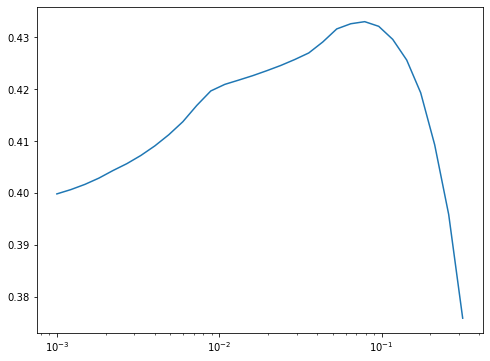

In [62]:
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

plot error lines showing +/- std. errors of the scores

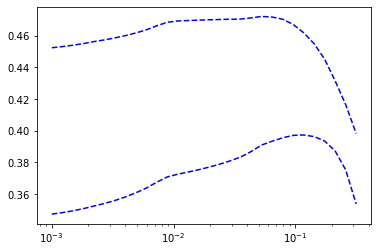

In [63]:
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

alpha=0.2 controls the translucency of the fill color

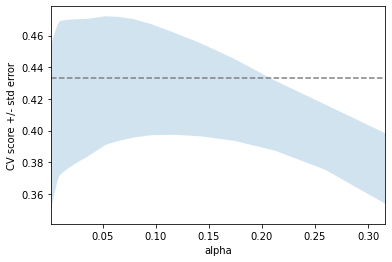

In [64]:
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

plt.show()

Finally, now that we have our selected labels, we can use them to select the numpy array
columns that we want to use for a post-LASSO run.

In [65]:
new_x = X[:, selected_coefficient_indices]

print('new_x', new_x)

new_x [[ 0.03807591  0.05068012  0.06169621 ... -0.04340085  0.01990842
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ...  0.07441156 -0.06832974
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.03235593  0.00286377
  -0.02593034]
 ...
 [-0.05637009 -0.04464164  0.09295276 ... -0.02867429  0.02605609
   0.04034337]
 [-0.06000263  0.05068012  0.01535029 ...  0.019187   -0.03075121
  -0.0010777 ]
 [-0.04910502  0.05068012 -0.00512814 ... -0.06917231  0.06123791
  -0.03835666]]


Plug this new x matrix into our statsmodels OLS function and print that out.
How is this better than a vanilla OLS?

In [66]:
result = OLS(y, new_x).fit().summary()

print(result)



                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.108
Model:                            OLS   Adj. R-squared (uncentered):              0.058
Method:                 Least Squares   F-statistic:                              2.157
Date:                Tue, 07 Dec 2021   Prob (F-statistic):                      0.0342
Time:                        13:53:59   Log-Likelihood:                         -970.70
No. Observations:                 150   AIC:                                      1957.
Df Residuals:                     142   BIC:                                      1981.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------